In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from uplift.metrics import uplift_curve, optimal_uplift_curve, null_uplift_curve, qini_Q, qini_q
from math import log, log2

%matplotlib inline
rng = np.random.RandomState(1)

/usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def display_uplift_charts(y_true, d_pred, group):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(*optimal_uplift_curve(y_true, group, negative_effects=True))
    ax2.plot(*optimal_uplift_curve(y_true, group, negative_effects=False))

    ax1.plot(*uplift_curve(y_true, d_pred, group))
    ax2.plot(*uplift_curve(y_true, d_pred, group))

    ax1.plot(*null_uplift_curve(y_true, group), color='lightgray')
    ax2.plot(*null_uplift_curve(y_true, group), color='lightgray')

# Synthetic data

In [3]:
def Radcliffe_Surry_example():
    N = 64000
    df = pd.DataFrame({'a': rng.rand(N), 'b': rng.rand(N), 'group': rng.binomial(1, 0.5, size=N)})

    def true_response_probability(a, b, group, **kargs):
        nrm = (1/2 + 1/10 + 3/100)
        if group == 0:
            return (a/2)/nrm
        else:
            return (a/2 + b/10 + 3/100)/nrm

    def true_uplift_probability(a, b, **kargs):
        return true_response_probability(a, b, 1) - true_response_probability(a, b, 0)

    df['p'] = df.apply(lambda row: true_response_probability(**row), axis=1)
    df['d'] = df.apply(lambda row: true_uplift_probability(**row), axis=1)
    df['y'] = df['p'].apply(lambda p: rng.binomial(1, p))
    
    return df
    
df_train = Radcliffe_Surry_example()[['a', 'b', 'group', 'y']]
df_test = df = Radcliffe_Surry_example()

# Uplift curve

0.0341393817409 0.186213726162


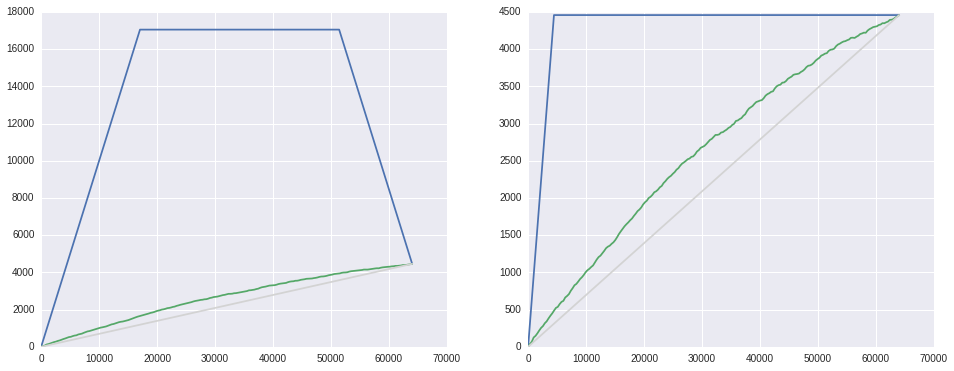

In [4]:
display_uplift_charts(df.y, df.d, df.group)
print(qini_Q(df.y, df.d, df.group), qini_q(df.y, df.d, df.group))

# Double model

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# fit
rfc0 = RandomForestClassifier(n_estimators=100)
rfc1 = RandomForestClassifier(n_estimators=100)

# rfc0 = LogisticRegression()
# rfc1 = LogisticRegression()

control_train = df_train[df_train.group == 0]
rfc0.fit(control_train[['a', 'b']].values, control_train.y.values)

target_train = df_train[df_train.group == 1]
rfc1.fit(target_train[['a', 'b']].values, target_train.y.values)

# predict
df_double_model = df_test.copy()
p_control = rfc0.predict_proba(df_test[['a', 'b']].values)[:,1]
p_target = rfc1.predict_proba(df_test[['a', 'b']].values)[:,1]
df_double_model['d'] = p_target - p_control

0.00997233800133 0.0543942544673


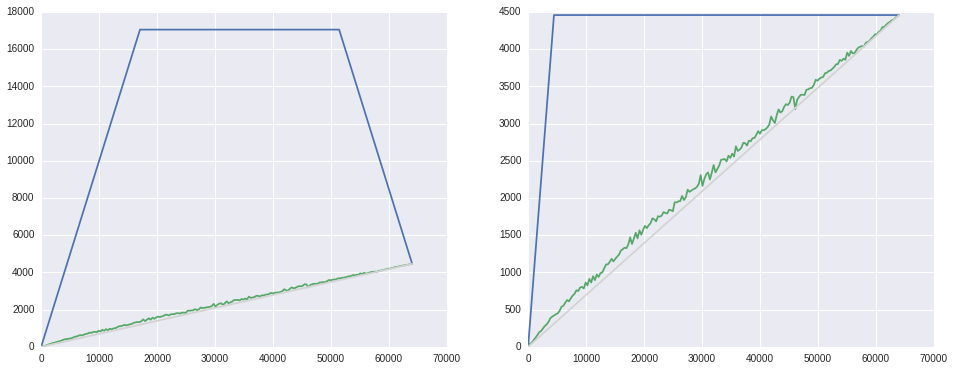

In [6]:
display_uplift_charts(df_double_model.y, df_double_model.d, df_double_model.group)
print(qini_Q(df_double_model.y, df_double_model.d, df_double_model.group), 
      qini_q(df_double_model.y, df_double_model.d, df_double_model.group))

# Lo model

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

df_train_Lo = df_train.copy()
df_train_Lo['at'] = df_train_Lo['a'] * df_train_Lo['group']
df_train_Lo['bt'] = df_train_Lo['b'] * df_train_Lo['group']

rfc = RandomForestClassifier(n_estimators=100)
# rfc = LogisticRegression()
rfc.fit(df_train_Lo[['a', 'b', 'at', 'bt', 'group']], df_train_Lo.y)

df_Lo = df_test.copy()

df_Lo['at'] = df_Lo['a'] * 1
df_Lo['bt'] = df_Lo['b'] * 1
df_Lo['group'] = 1

p_target = rfc.predict_proba(df_Lo[['a', 'b', 'at', 'bt', 'group']])[:,1]

df_Lo['at'] = 0
df_Lo['bt'] = 0
df_Lo['group'] = 0

p_control = rfc.predict_proba(df_Lo[['a', 'b', 'at', 'bt', 'group']])[:,1]

df_Lo['group'] = df_test['group']
df_Lo['d'] = p_target - p_control

0.00805735559869 0.0439489566749


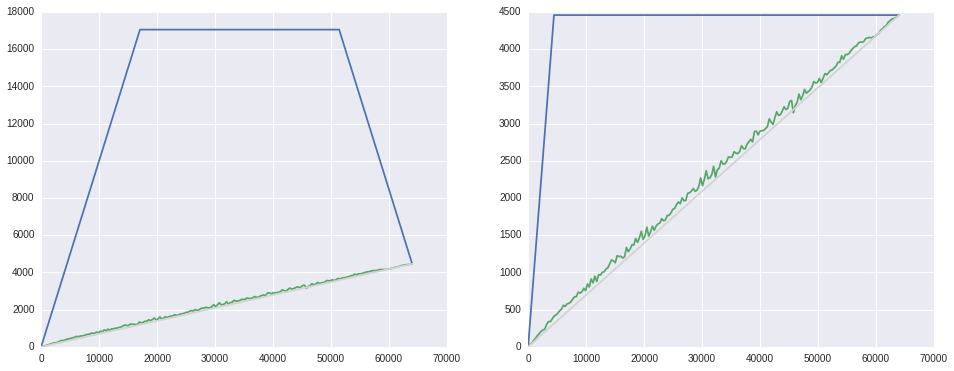

In [8]:
display_uplift_charts(df_Lo.y, df_Lo.d, df_Lo.group)
print(qini_Q(df_Lo.y, df_Lo.d, df_Lo.group), qini_q(df_Lo.y, df_Lo.d, df_Lo.group))

# Uplift Random Forest Classifier

In [9]:
from uplift.ensemble import UpliftRandomForestClassifier

urfc = UpliftRandomForestClassifier(n_estimators=100, min_samples_leaf=200, criterion='uplift_entropy')
urfc.fit(df_train[['a', 'b']].values, df_train.y.values, df_train.group.values)

# predict
df_urfc = df_test.copy()
df_urfc['d'] = urfc.predict_proba(df_test[['a', 'b']].values)

0.0319958596909 0.174521855726


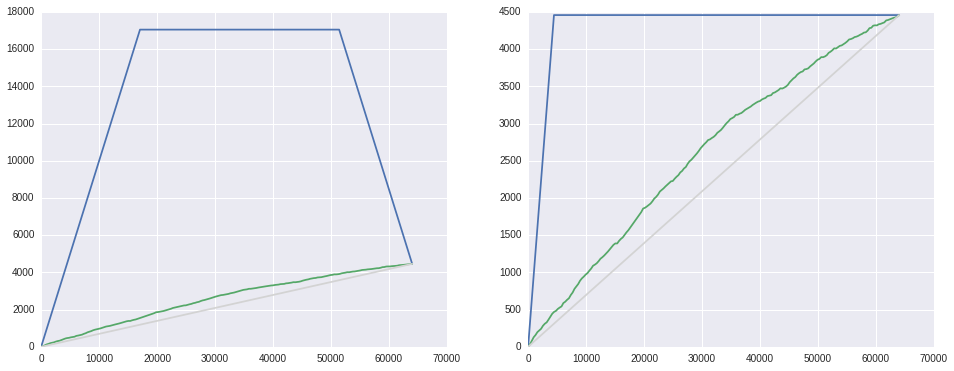

In [10]:
display_uplift_charts(df_urfc.y, df_urfc.d, df_urfc.group)
print(qini_Q(df_urfc.y, df_urfc.d, df_urfc.group), qini_q(df_urfc.y, df_urfc.d, df_urfc.group))